## Import library

In [1]:
import tqdm.notebook as tq
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Config PhoBERT

#### Set training stats

In [2]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5

#### Using PhoBERT tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

#### Implement data format converter

In [4]:
class IntentsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text_clean'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

#### Define PhoBERT model

In [5]:
class PhoBertIntentsRecognition(nn.Module):
    def __init__(self):
        super(PhoBertIntentsRecognition, self).__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = torch.nn.Dropout(p=0.3)
        self.linear = nn.Linear(768, 9)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.phobert(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [6]:
model = PhoBertIntentsRecognition()
model.to(device)

PhoBertIntentsRecognition(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Layer

#### Define optimizer

In [7]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = AdamW(model.parameters(), lr=1e-5)

#### Define training function

In [8]:
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return model, float(correct_predictions)/num_samples, np.mean(losses)

#### Define evaluating function

In [9]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size

    return float(correct_predictions)/num_samples, np.mean(losses)

## Train model with 100% data from ChatGPT

#### Read data

In [11]:
chatgpt_100_data = pd.read_excel("../data/labeled/intent/intents_100_chatgpt.xlsx").fillna(0)
chatgpt_100_data.head(5)

,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,text_clean
0,0,0,1,0,0,0,0,0,0,"hai pizza double cheese burger cỡ nhỏ, không t..."
1,0,0,1,0,0,0,0,0,0,"thèm thêm một chiếc pizza bbq chicken nữa, nhớ đó"
2,0,0,1,0,0,0,0,0,0,"làm thêm một pizza margherita, size vừa, crust..."
3,0,0,1,0,0,0,0,0,0,"gọi pizza meat lovers, cỡ nhỏ, thêm nấm rơm và..."
4,0,0,1,0,0,0,0,0,0,"đặt một pizza giống như lần trước, cảm ơn nhé"


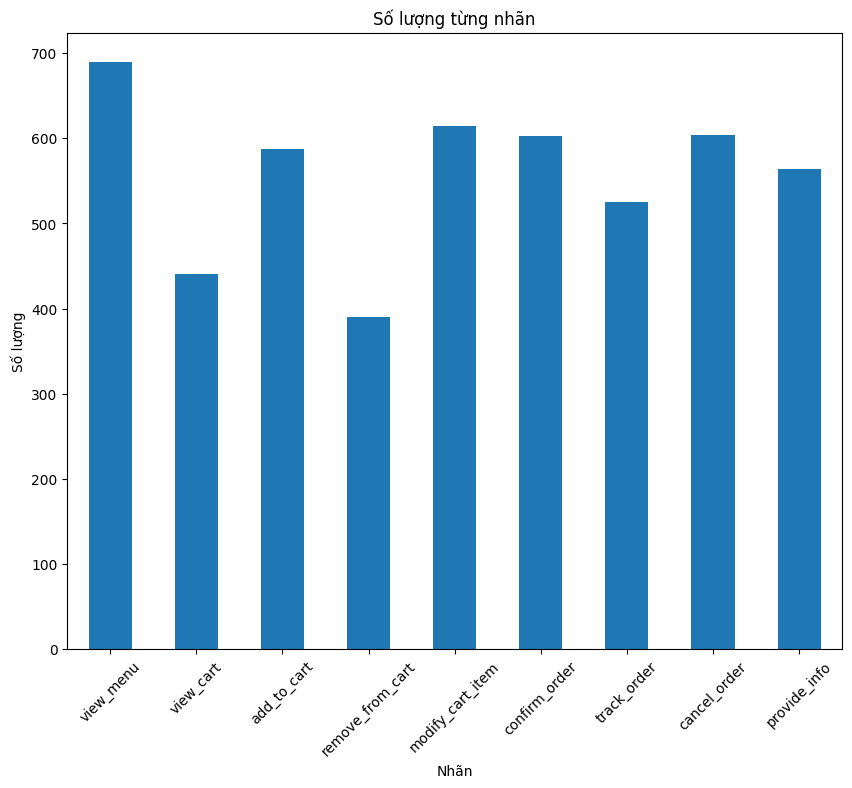

In [12]:
chatgpt_100_label_counts = chatgpt_100_data.drop(columns=['text_clean']).sum()

plt.figure(figsize=(10, 8))
chatgpt_100_label_counts.plot(kind='bar')
plt.title('Số lượng từng nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

#### Split train test

In [1]:
chatgpt_100_train, chatgpt_100_valid = train_test_split(chatgpt_100_data, random_state=77, test_size=0.2, shuffle=True)
print(f"Train: {chatgpt_100_train.shape}, Valid: {chatgpt_100_valid.shape}")

Train: (4000, 10), Valid: (1000, 10)


#### Get labels list

In [14]:
chatgpt_100_target_list = list(chatgpt_100_data.columns)
chatgpt_100_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'text_clean']

In [15]:
chatgpt_100_target_list = chatgpt_100_target_list[:9]
chatgpt_100_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info']

#### Convert data format to desired format for PhoBERT

In [16]:
chatgpt_100_train_dataset = IntentsDataset(chatgpt_100_train, tokenizer, MAX_LEN, chatgpt_100_target_list)
chatgpt_100_valid_dataset = IntentsDataset(chatgpt_100_valid, tokenizer, MAX_LEN, chatgpt_100_target_list)

In [17]:
chatgpt_100_train_data_loader = DataLoader(chatgpt_100_train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

chatgpt_100_val_data_loader = DataLoader(chatgpt_100_valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

#### Train model

In [18]:
chatgpt_100_history = defaultdict(list)
chatgpt_100_best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(chatgpt_100_train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(chatgpt_100_val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    chatgpt_100_history['train_acc'].append(train_acc)
    chatgpt_100_history['train_loss'].append(train_loss)
    chatgpt_100_history['val_acc'].append(val_acc)
    chatgpt_100_history['val_loss'].append(val_loss)

    if val_acc > chatgpt_100_best_accuracy:
        torch.save(model.state_dict(), "intents_100_chatgpt.bin")
        chatgpt_100_best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.3809, val_loss=0.2910 train_acc=0.8818, val_acc=0.8896
Epoch 2/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.2334, val_loss=0.1594 train_acc=0.9182, val_acc=0.9764
Epoch 3/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.1318, val_loss=0.1004 train_acc=0.9824, val_acc=0.9860
Epoch 4/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0854, val_loss=0.0759 train_acc=0.9921, val_acc=0.9876
Epoch 5/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0614, val_loss=0.0620 train_acc=0.9943, val_acc=0.9884
Epoch 6/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0487, val_loss=0.0584 train_acc=0.9949, val_acc=0.9880
Epoch 7/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0380, val_loss=0.0583 train_acc=0.9959, val_acc=0.9867
Epoch 8/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0317, val_loss=0.0511 train_acc=0.9965, val_acc=0.9878
Epoch 9/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0272, val_loss=0.0496 train_acc=0.9967, val_acc=0.9867
Epoch 10/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0227, val_loss=0.0442 train_acc=0.9975, val_acc=0.9898


In [11]:
chatgpt_100_history_temp = {
    "train_loss": [0.3809, 0.2334, 0.1318, 0.0854, 0.0614, 0.0487, 0.0380, 0.0317, 0.0272, 0.0227],
    "val_loss": [0.2910, 0.1594, 0.1004, 0.0759, 0.0620, 0.0584, 0.0583, 0.0511, 0.0496, 0.0442],
    "train_acc": [0.8818, 0.9182, 0.9824, 0.9921, 0.9943, 0.9949, 0.9959, 0.9965, 0.9967, 0.9975],
    "val_acc": [0.8896, 0.9764, 0.9860, 0.9876, 0.9884, 0.9880, 0.9867, 0.9878, 0.9867, 0.9898]
}

##### Training performance

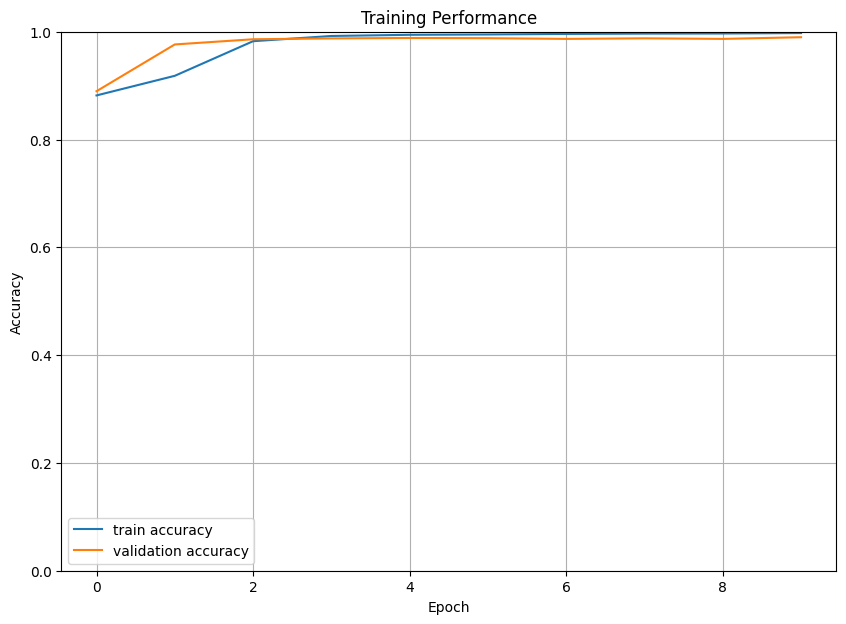

In [12]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(chatgpt_100_history_temp['train_acc'], label='train accuracy')
plt.plot(chatgpt_100_history_temp['val_acc'], label='validation accuracy')
plt.title('Training Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

#### Loss Curve

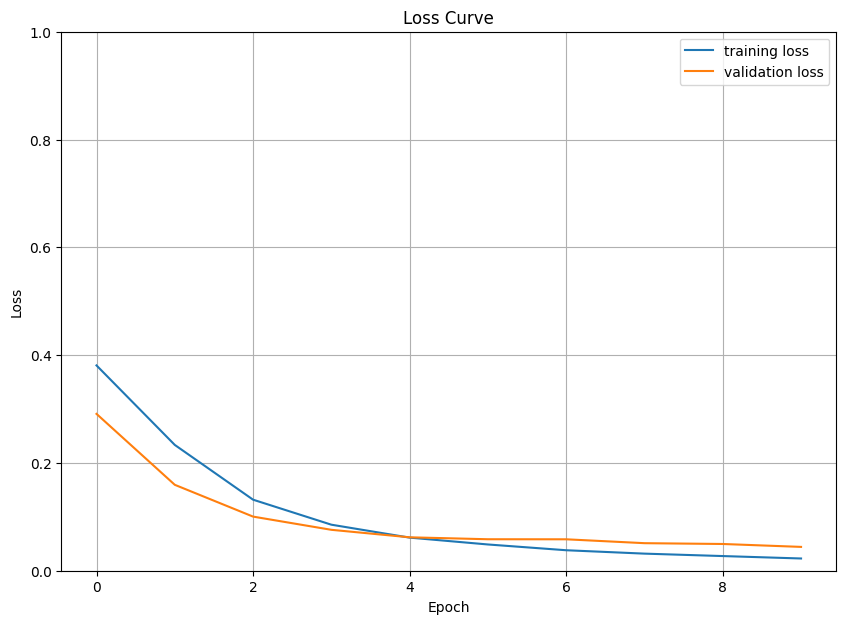

In [13]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(chatgpt_100_history_temp['train_loss'], label='training loss')
plt.plot(chatgpt_100_history_temp['val_loss'], label='validation loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Train model with 100% data from Human

#### Read data

In [21]:
human_100_data = pd.read_excel("../data/labeled/intent/intents_100_human.xlsx").fillna(0)
human_100_data.head(5)

,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,text_clean
0,1,0,0,0,0,0,0,0,0,cái pizza new oceania đó hết bao nhiêu tiền vậ...
1,1,0,0,0,0,0,0,0,0,cái pizza margherita có mắc không
2,1,0,0,0,0,0,0,0,0,cho mình hỏi pizza có thêm topping không
3,1,0,0,0,0,0,0,0,0,bạn ơi cái pizza pepperoni giá sao vậy
4,1,0,0,0,0,0,0,0,0,bán cái pizza này bao nhiêu tiền vậy


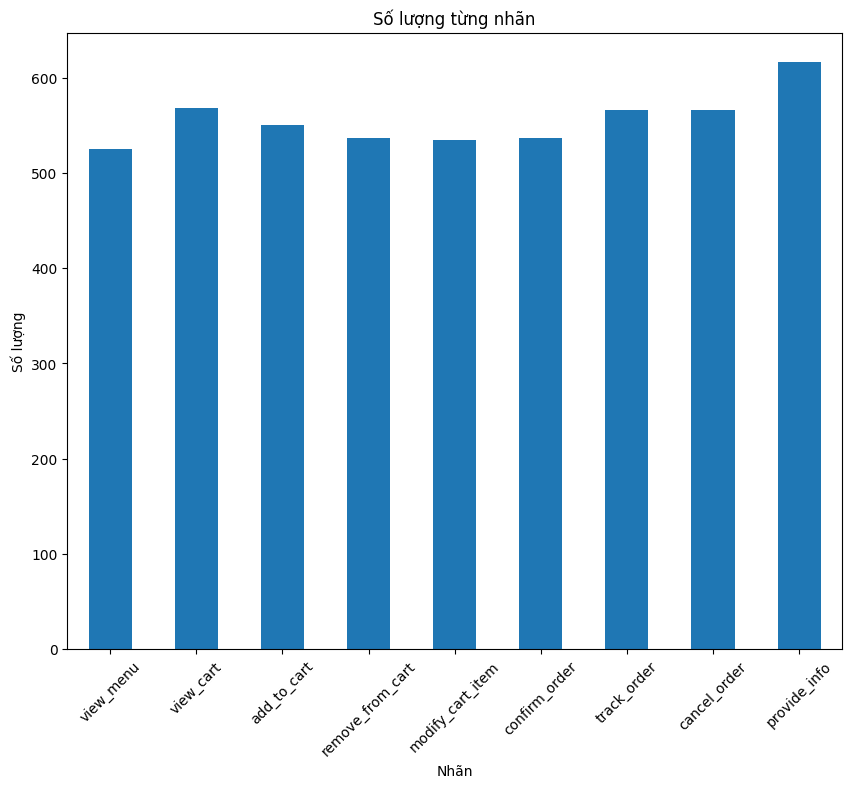

In [22]:
human_100_label_counts = human_100_data.drop(columns=['text_clean']).sum()

plt.figure(figsize=(10, 8))
human_100_label_counts.plot(kind='bar')
plt.title('Số lượng từng nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

#### Split train test

In [2]:
human_100_train, human_100_valid = train_test_split(human_100_data, random_state=77, test_size=0.2, shuffle=True)
print(f"Train: {human_100_train.shape}, Valid: {human_100_valid.shape}")

Train: (4000, 10), Valid: (1000, 10)


#### Get labels list

In [24]:
human_100_target_list = list(human_100_data.columns)
human_100_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'text_clean']

In [25]:
human_100_target_list = human_100_target_list[:9]
human_100_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info']

#### Change data format to desired format for PhoBERT

In [26]:
human_100_train_dataset = IntentsDataset(human_100_train, tokenizer, MAX_LEN, human_100_target_list)
human_100_valid_dataset = IntentsDataset(human_100_valid, tokenizer, MAX_LEN, human_100_target_list)

In [27]:
human_100_train_data_loader = DataLoader(human_100_train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

human_100_val_data_loader = DataLoader(human_100_valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

#### Train model

In [29]:
human_100_history = defaultdict(list)
human_100_best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(human_100_train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(human_100_val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    human_100_history['train_acc'].append(train_acc)
    human_100_history['train_loss'].append(train_loss)
    human_100_history['val_acc'].append(val_acc)
    human_100_history['val_loss'].append(val_loss)

    if val_acc > human_100_best_accuracy:
        torch.save(model.state_dict(), "intents_100_human.bin")
        human_100_best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0613, val_loss=0.0454 train_acc=0.9823, val_acc=0.9880
Epoch 2/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0302, val_loss=0.0377 train_acc=0.9929, val_acc=0.9907
Epoch 3/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0200, val_loss=0.0246 train_acc=0.9964, val_acc=0.9936
Epoch 4/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0131, val_loss=0.0210 train_acc=0.9986, val_acc=0.9960
Epoch 5/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0105, val_loss=0.0221 train_acc=0.9991, val_acc=0.9953
Epoch 6/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0073, val_loss=0.0222 train_acc=0.9994, val_acc=0.9944
Epoch 7/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0070, val_loss=0.0220 train_acc=0.9994, val_acc=0.9951
Epoch 8/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0067, val_loss=0.0201 train_acc=0.9994, val_acc=0.9953
Epoch 9/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0049, val_loss=0.0288 train_acc=0.9996, val_acc=0.9938
Epoch 10/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0047, val_loss=0.0191 train_acc=0.9997, val_acc=0.9956


In [4]:
human_100_history_temp = {
    "train_loss": [0.0613, 0.0302, 0.0200, 0.0131, 0.0105, 0.0073, 0.0070, 0.0067, 0.0049, 0.0047],
    "val_loss": [0.0454, 0.0377, 0.0246, 0.0210, 0.0221, 0.0222, 0.0220, 0.0201, 0.0288, 0.0191],
    "train_acc": [0.9823, 0.9929, 0.9964, 0.9986, 0.9991, 0.9994, 0.9994, 0.9994, 0.9996, 0.9997],
    "val_acc": [0.9880, 0.9907, 0.9936, 0.9960, 0.9953, 0.9944, 0.9951, 0.9953, 0.9938, 0.9956]
}

##### Training performance

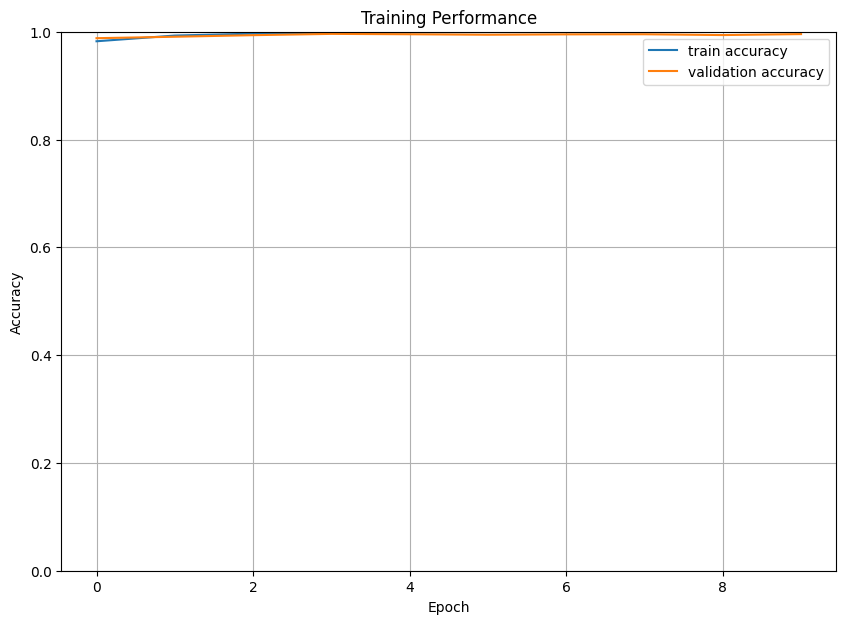

In [5]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(human_100_history_temp['train_acc'], label='train accuracy')
plt.plot(human_100_history_temp['val_acc'], label='validation accuracy')
plt.title('Training Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

#### Loss Curve

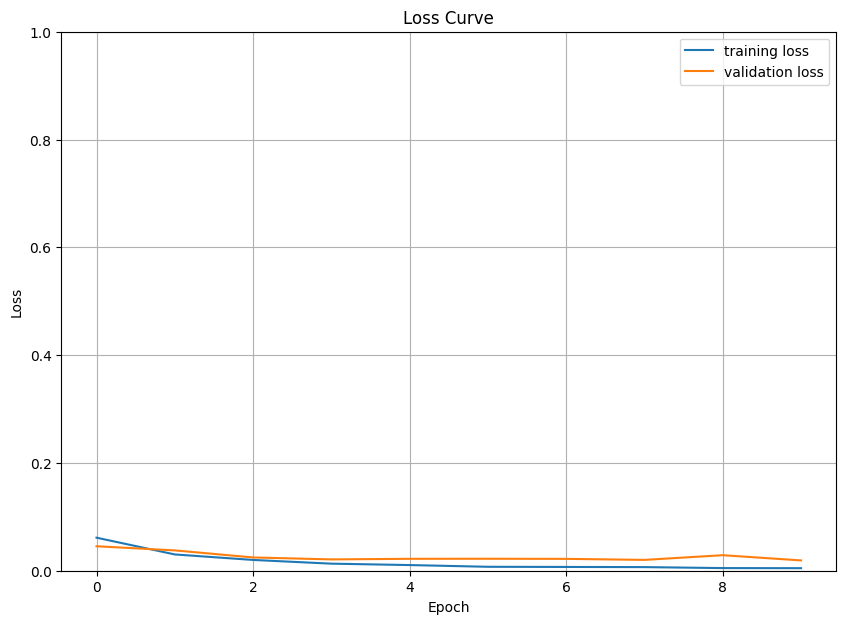

In [7]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(human_100_history_temp['train_loss'], label='training loss')
plt.plot(human_100_history_temp['val_loss'], label='validation loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Train model using data 50% mix of human and 50% ChatGPT

#### Read data

In [31]:
chatgpt_50_human_50_data = pd.read_excel("../data/labeled/intent/intents_50_chatgpt_50_human.xlsx").fillna(0)
chatgpt_50_human_50_data.head(5)

,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,text_clean
0,0,0,0,0,0,0,0,1,0,"cancel đơn hàng của tớ đi, tạm thời không ăn p..."
1,0,1,0,0,0,0,0,0,0,muon kiem tra lai gio hang đã chọn
2,0,0,0,0,0,0,0,1,0,"hủy đơn hàng này đi, tôi thay đổi ý rồi"
3,0,0,0,0,1,0,0,0,0,có thể thay đường với thịt bò xay trên pizza p...
4,0,0,0,0,1,0,0,0,0,"topping: phômát, jăm bông, gà"


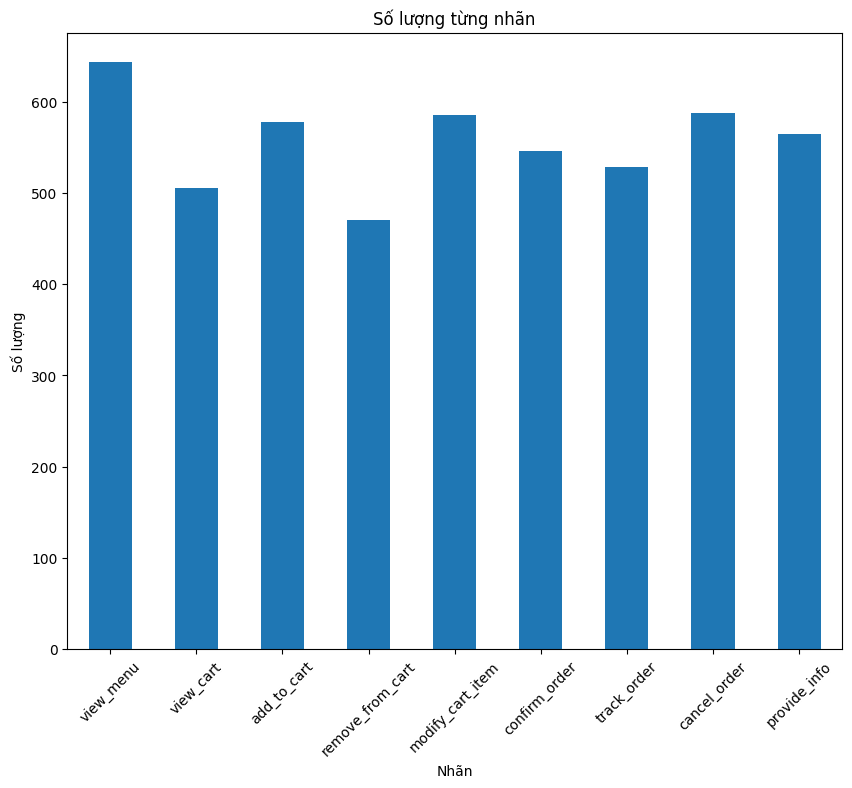

In [32]:
chatgpt_50_human_50_label_counts = chatgpt_50_human_50_data.drop(columns=['text_clean']).sum()

plt.figure(figsize=(10, 8))
chatgpt_50_human_50_label_counts.plot(kind='bar')
plt.title('Số lượng từng nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

#### Split train test

In [3]:
chatgpt_50_human_50_train, chatgpt_50_human_50_valid = train_test_split(chatgpt_50_human_50_data, random_state=77, test_size=0.2, shuffle=True)
print(f"Train: {chatgpt_50_human_50_train.shape}, Valid: {chatgpt_50_human_50_valid.shape}")

Train: (4000, 10), Valid: (1000, 10)


#### Get labels list

In [34]:
chatgpt_50_human_50_target_list = list(chatgpt_50_human_50_data.columns)
chatgpt_50_human_50_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'text_clean']

In [35]:
chatgpt_50_human_50_target_list = chatgpt_50_human_50_target_list[:9]
chatgpt_50_human_50_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info']

#### Change data format to desired format for PhoBERT

In [36]:
chatgpt_50_human_50_train_dataset = IntentsDataset(chatgpt_50_human_50_train, tokenizer, MAX_LEN, chatgpt_50_human_50_target_list)
chatgpt_50_human_50_valid_dataset = IntentsDataset(chatgpt_50_human_50_valid, tokenizer, MAX_LEN, chatgpt_50_human_50_target_list)

In [37]:
chatgpt_50_human_50_train_data_loader = DataLoader(chatgpt_50_human_50_train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

chatgpt_50_human_50_val_data_loader = DataLoader(chatgpt_50_human_50_valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

#### Train model

In [38]:
chatgpt_50_human_50_history = defaultdict(list)
chatgpt_50_human_50_best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(chatgpt_50_human_50_train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(chatgpt_50_human_50_val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    chatgpt_50_human_50_history['train_acc'].append(train_acc)
    chatgpt_50_human_50_history['train_loss'].append(train_loss)
    chatgpt_50_human_50_history['val_acc'].append(val_acc)
    chatgpt_50_human_50_history['val_loss'].append(val_loss)

    if val_acc > chatgpt_50_human_50_best_accuracy:
        torch.save(model.state_dict(), "intents_50_chatgpt_50_human.bin")
        chatgpt_50_human_50_best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0290, val_loss=0.0157 train_acc=0.9927, val_acc=0.9971
Epoch 2/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0171, val_loss=0.0122 train_acc=0.9959, val_acc=0.9967
Epoch 3/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0116, val_loss=0.0130 train_acc=0.9975, val_acc=0.9973
Epoch 4/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0105, val_loss=0.0132 train_acc=0.9978, val_acc=0.9971
Epoch 5/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0082, val_loss=0.0142 train_acc=0.9986, val_acc=0.9971
Epoch 6/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0071, val_loss=0.0146 train_acc=0.9985, val_acc=0.9967
Epoch 7/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0066, val_loss=0.0165 train_acc=0.9986, val_acc=0.9964
Epoch 8/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0059, val_loss=0.0112 train_acc=0.9988, val_acc=0.9976
Epoch 9/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0053, val_loss=0.0161 train_acc=0.9990, val_acc=0.9962
Epoch 10/10


  0%|          | 0/250 [00:00<?, ?it/s]

train_loss=0.0045, val_loss=0.0142 train_acc=0.9991, val_acc=0.9967


In [8]:
chatgpt_50_human_50_history_temp = {
    "train_loss": [0.0290, 0.0171, 0.0116, 0.0105, 0.0082, 0.0071, 0.0066, 0.0059, 0.0053, 0.0045],
    "val_loss": [0.0127, 0.0122, 0.0130, 0.0132, 0.0142, 0.0146, 0.0165, 0.0112, 0.0161, 0.0142],
    "train_acc": [0.9927, 0.9959, 0.9975, 0.9978, 0.9986, 0.9985, 0.9986, 0.9988, 0.9990, 0.9991],
    "val_acc": [0.9971, 0.9967, 0.9973, 0.9971, 0.9971, 0.9967, 0.9964, 0.9976, 0.9962, 0.9967]
}

##### Training performance

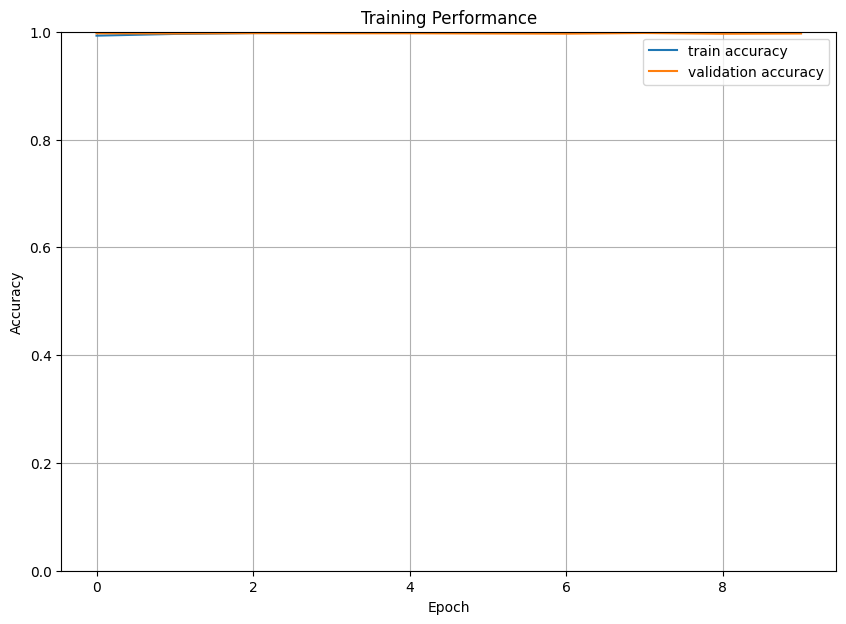

In [9]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(chatgpt_50_human_50_history_temp['train_acc'], label='train accuracy')
plt.plot(chatgpt_50_human_50_history_temp['val_acc'], label='validation accuracy')
plt.title('Training Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

#### Loss Curve

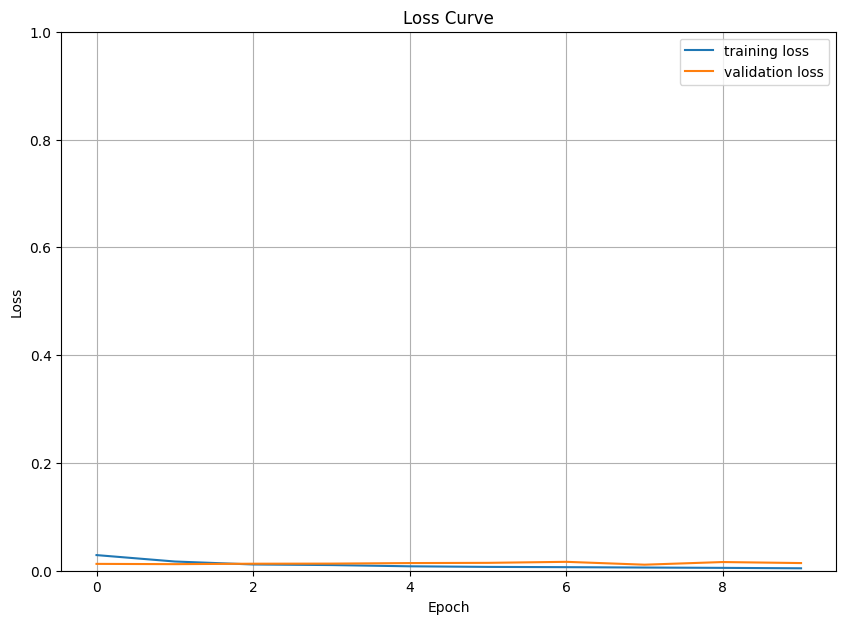

In [10]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(chatgpt_50_human_50_history_temp['train_loss'], label='training loss')
plt.plot(chatgpt_50_human_50_history_temp['val_loss'], label='validation loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()